## Class 3 - L1 and L2 regularization
In our this lecture, we discussed some foundational concepts in data science, namely *overfitting*, the *bias-variance* trade-off, and *regularization*.
Today, we will apply some of these concepts to interpret and improve the performance of our predictive models, focusing especially on regularization.

AS usual, we will do all of this using `scikit-learn`.

**Note**: As last week, under `nbs/class_03` you will find a notebook called `example.ipynb`, where I provide an example of how to run today's exercise on sample data.
Some of it repeats things done as part of `class_02`, for the sake of completeness.
But you can also:
- just keep working on the same notebook as last week
- work in a new notebook, but load data splits and models that have saved last week

### Today's exercise
Gather in the same group as last week, and please go through the following steps:
1. Look back at last week's notebook. If you have not applied any transformation to your input because you did not have time, spend some time thinking about whether it would make sense to do so. You can find relevant transformations in `scikit-learn`: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing. You will probably mostly be interested in `StandardScaler` and `MinMaxScaler`
2. Look at the performance of the models you've fitted last week: what is the best model? Do you see any evidence of overfitting?
3. Fit your maximal models with `Lasso` (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) and `Ridge` (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) estimators instead of `LinearRegression`. Make sure you look at the documentation to understand what these do. Fit multiple models with multiple values of alpha and store the outputs;
4. Plot the performance of your models against your linear and KNN models from last week. Does the performance of the model on the validation set improve with regularization?
5. For both `Lasso` and `Ridge` models, plot the value of the coefficients as a function of alpha. You can access the coefficients for a fitted `model` through `model.coef_`. What do you notice in terms of how LASSO versus Ridge behave? (Look at `example.ipynb` for inspiration)
6. Finally, if any models are doing better than the linear model without regularization, select the best `Ridge` and the best `Lasso` model, and plot their coefficients, alongsize coefficients from the simple linear models. How do estimates change with regularization? Which values have changed the most? Do you have any hypothesis as to why?

### Once you have done this
Please submit a pull request to my repository where, within `nbs/class_03/group-x` you have the notebook on which you have worked.
If your notebook is the same as last week, please push that one.

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns

import pickle as pkl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression,  Lasso, Ridge

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

bike_dat = pd.read_csv('/work/data/class_01/bikes.csv')

In [6]:
bike_dat.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


### Train-dev-test split
Let's use scikit-learn's utils to create three data splits. First, we need to get our data to numpy arrays. This can be done easily in pandas. Note that we want to create 70/15/15 splits.

In [58]:
X = bike_dat[['windspeed', 'temp']]
y = bike_dat[['cnt']]

X

,windspeed,temp
0,0.0000,0.24
1,0.0000,0.22
2,0.0000,0.22
3,0.0000,0.24
4,0.0000,0.24
...,...,...
17374,0.1642,0.26
17375,0.1642,0.26
17376,0.1642,0.26
17377,0.1343,0.26


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15,
                                                    shuffle=True,
                                                    random_state=42) # this is done 
                                                    

# let's further split the training set into a training and a validation set (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=0.15,  
                                                  shuffle=True,
                                                  random_state=42)

In [ ]:

# let's further split the training set into a training and a validation set (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=0.15,  
                                                  shuffle=True,
                                                random_state=42)

### Standardization 
we do this so that we can regularize later

We only do the standardization relatively to the training set, because this is in theory all we have available. But the val and test still needs to be standardized, but by the mean and sd given in the training data. 

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Mean Model

In [61]:
performances = []

In [62]:
mean_value = y_train.mean()
model_name = 'dummy'

for y,nsplit in zip([y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    performance = np.sqrt(mean_squared_error(y, 
                                             [mean_value]*y.shape[0]))
    r2 = r2_score(y, [mean_value]*y.shape[0])
    performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [63]:
performances

[{'model': 'dummy', 'split': 'train', 'rmse': 183.2777, 'r2': 0.0},
 {'model': 'dummy', 'split': 'val', 'rmse': 174.3804, 'r2': -0.0016},
 {'model': 'dummy', 'split': 'test', 'rmse': 178.0742, 'r2': -0.0013}]

#### Lin Reg

In [64]:
reg = LinearRegression().fit(X_train, y_train)

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = reg.predict(x)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'linear',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [54]:
performances

[{'model': 'dummy', 'split': 'train', 'rmse': 156.975, 'r2': 0.0},
 {'model': 'dummy', 'split': 'val', 'rmse': 251.1246, 'r2': -0.2775},
 {'model': 'dummy', 'split': 'test', 'rmse': 226.8089, 'r2': -0.1118},
 {'model': 'linear-demographics',
  'split': 'train',
  'rmse': 142.4435,
  'r2': 0.1766},
 {'model': 'linear-demographics',
  'split': 'val',
  'rmse': 212.9799,
  'r2': 0.0811},
 {'model': 'linear-demographics',
  'split': 'test',
  'rmse': 218.2354,
  'r2': -0.0294}]

In [67]:
perf_df = pd.DataFrame(performances)

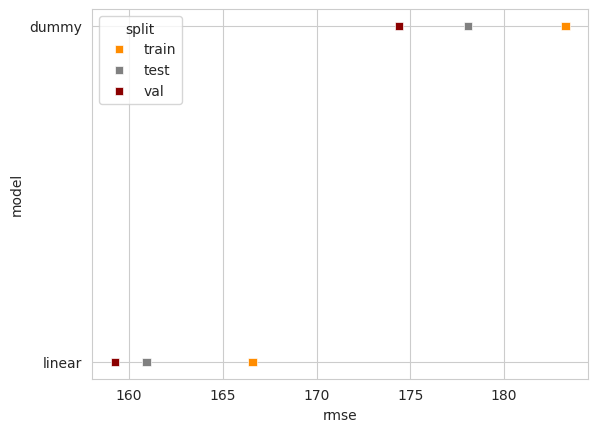

In [68]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

#### Regularization 
with Lasso and Ridge

In [70]:
models = {} # storing fitted models in the next chunk
models['linear-0.0'] = reg

In [74]:
def evaluate(model, X, y, nsplit, model_name, constant_value=None):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): string id of the model
        constant_value (int or None): relevant if the model predicts a constant
    '''
    if constant_value is not None:
        preds = np.array([constant_value] * y.shape[0])
    else:
        preds = model.predict(X)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [75]:
for alpha in [0.01, 0.1, 0.2, 0.5, 1.0, 20.0, 10.0, 100.0, 1000.0]:
    for est in [Lasso, Ridge]:
        if est == Lasso:
            id = 'lasso'
        else:
            id = 'ridge'
        reg = est(alpha=alpha).fit(X_train, y_train)
        models[f'{id}-{alpha}'] = reg
        for x,y,nsplit in zip([X_train, X_val, X_test],
                            [y_train, y_val, y_test],
                            ['train', 'val', 'test']):
            evaluate(model=reg, 
                    X=x, y=y, 
                    nsplit=nsplit, 
                    model_name=f'linear-{id}-alpha-{alpha}')

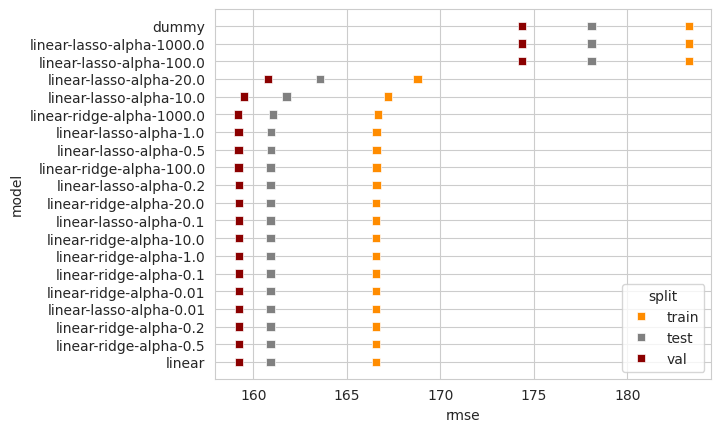

In [76]:
perf_df = pd.DataFrame(performances)
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

her kan 

In [80]:
coefs = pd.DataFrame(np.vstack([v.coef_.round(4) for v in models.values()]),
                     columns=X.iloc[:,:10].columns)
coefs['mtype'] = [k.split('-')[0] for k in models.keys()]
coefs['alpha'] = [float(k.split('-')[1]) for k in models.keys()]
coefs = pd.melt(coefs, id_vars=['mtype', 'alpha'])# turning data into long format 

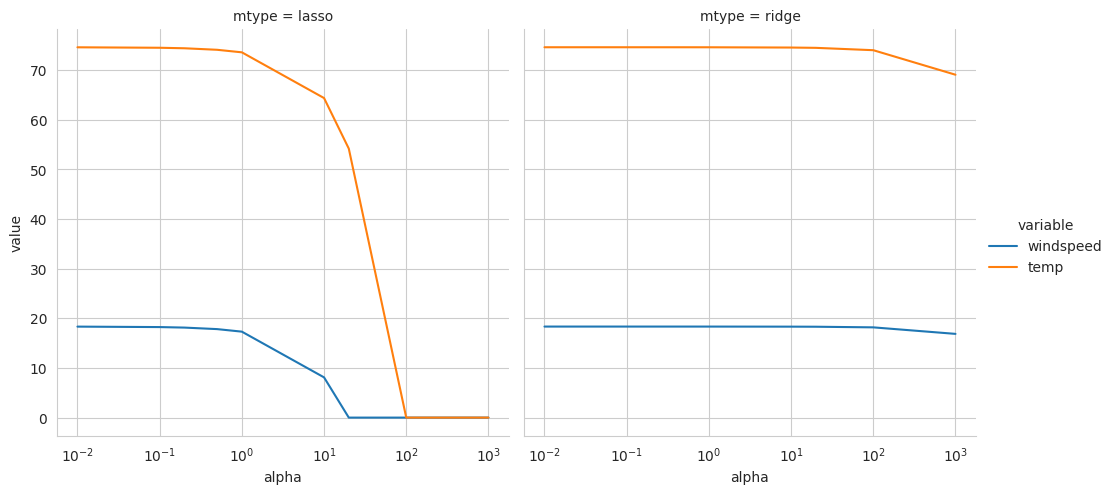

In [82]:
grid = sns.relplot(data=coefs[coefs['mtype']!='linear'], 
                   x='alpha', y='value', 
                   hue='variable', col='mtype', kind='line')
grid.set(xscale="log")